# Testing out Random Forest

### Imports

In [1]:
import sys
import os

from pure_eval import Evaluator
from sklearn.ensemble import RandomForestRegressor

sys.path.append(os.path.abspath('..'))

In [17]:
from venus_ml import HyperparameterTuner, EvaluationManager, RandomForest, VenusDataset, standardize
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
import pandas as pd
import numpy as np

### Data config and dataset initialization

In [3]:
def get_features(names, mean=True, std=False):
    out_list = []
    for name in names:
        if mean:
            out_list.append(name + "_mean")
        if std:
            out_list.append(name + "_std")
    return out_list

In [4]:
tiny_list = ["inj_mbar", "bias_v", "bias_i", "extraction_i"]
less_tiny_list = tiny_list + ["inj_i", "ext_i", "mid_i", "sext_i", "x_ray_source", "x_ray_exit"]
data_set_config = {
    "file_path": "../accumulated_weekend_data_2023_02_27.parquet",
    "input_columns": get_features(less_tiny_list),
    "output_columns": ["fcv1_i_mean"],
    "run_selection": (5.0, 6.0, 6.5, 7.0, 7.5, 8.0, 9.0) # leave out 10 for later testing
}
dataset = VenusDataset(**data_set_config)
X, y = dataset.to_numpy()
y = y.ravel()
print(X.shape, y.shape)

(8817, 10) (8817,)


### Initial Grid and Randomized Search

In [5]:
rf_model = RandomForest({})
parameter_grid = {
    "n_estimators": randint(50, 1500),
    "max_depth": randint(3, 50),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": [None, "sqrt", "log2"]
}

In [6]:
rf_tuner = HyperparameterTuner(rf_model, parameter_grid, search_method="random")
rf_tuner.fit(X, y, verbose=True)

/Users/ezraapple/miniforge3/envs/berkeley_lab/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RandomForestRegressor hyperparameters:
max_depth: 46
max_features: log2
min_samples_leaf: 1
min_samples_split: 3
n_estimators: 1087


### Adjusted Grid and Exhaustive Grid Search
Best RandomForestRegressor hyperparameters:
max_depth: 46
max_features: log2
min_samples_leaf: 1
min_samples_split: 3
n_estimators: 1087

In [7]:
rf_model = RandomForest({})
parameter_grid = {
    "n_estimators": [x for x in range(800, 1301, 100)],
    "max_depth": [x for x in range(35, 56, 5)] + [None],
    "min_samples_split": [2, 3, 4],
    "max_features": [None, "log2"]
}

In [8]:
rf_tuner = HyperparameterTuner(rf_model, parameter_grid, search_method="grid", verbosity=3)
rf_tuner.fit(X, y, verbose=True)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 5/5] END max_depth=35, max_features=None, min_samples_split=2, n_estimators=800;, score=0.571 total time=  22.7s
[CV 2/5] END max_depth=35, max_features=None, min_samples_split=2, n_estimators=1100;, score=0.955 total time=  31.3s


/Users/ezraapple/miniforge3/envs/berkeley_lab/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/5] END max_depth=35, max_features=None, min_samples_split=2, n_estimators=800;, score=0.971 total time=  23.6s
[CV 5/5] END max_depth=35, max_features=None, min_samples_split=2, n_estimators=1100;, score=0.578 total time=  31.2s
[CV 2/5] END max_depth=35, max_features=None, min_samples_split=2, n_estimators=800;, score=0.955 total time=  23.2s
[CV 3/5] END max_depth=35, max_features=None, min_samples_split=2, n_estimators=1100;, score=0.906 total time=  32.4s
[CV 3/5] END max_depth=35, max_features=None, min_samples_split=2, n_estimators=800;, score=0.905 total time=  23.3s
[CV 4/5] END max_depth=35, max_features=None, min_samples_split=2, n_estimators=1100;, score=-0.474 total time=  32.4s
[CV 4/5] END max_depth=35, max_features=None, min_samples_split=2, n_estimators=800;, score=-0.480 total time=  23.6s
[CV 1/5] END max_depth=35, max_features=None, min_samples_split=2, n_estimators=1200;, score=0.971 total time=  35.2s
[CV 2/5] END max_depth=35, max_features=None, min_samples_

### Get scores for best model
Best RandomForestRegressor hyperparameters:
max_depth: 45
max_features: log2
min_samples_split: 2
n_estimators: 1000

In [13]:
rf_args = {
    "n_estimators":1000, 
    "max_depth":45,
    "max_features": "log2"
}
rf = RandomForest(rf_args)
evaluator = EvaluationManager([rf], data_set_config)
evaluator.cross_evaluate(runs=(5.0, 6.0, 6.5, 7.0, 7.5, 8.0, 9.0))

In [19]:
evaluator.save_results("rf_cross_eval_results.csv")

In [20]:
results = pd.read_csv("rf_cross_eval_results.csv")
results

,validation_run,model,train_error,validation_error
0,5.0,RandomForest,6.570725e-11,4.667143e-09
1,6.0,RandomForest,5.750009e-11,3.472542e-09
2,6.5,RandomForest,6.914933e-11,1.387414e-08
3,7.0,RandomForest,5.302325e-11,2.321277e-09
4,7.5,RandomForest,4.522951e-11,3.727424e-09
5,8.0,RandomForest,5.575844e-11,7.167688e-09
6,9.0,RandomForest,4.959598e-11,7.339936e-09


### Train RF and show predictions versus targets

In [164]:
even_less_tiny_list = less_tiny_list + ["ext_mbar", "k18_fw", "k18_ref", "g28_fw", "puller_i"]
data_set_config = {
    "file_path": "../accumulated_weekend_data_2023_02_27.parquet",
    "input_columns": ["bias_v_mean", "bias_i_mean"],
    "output_columns": ["fcv1_i_mean"],
    "scaler": None,
    "run_selection": (5.0, 6.0, 6.5, 7.0, 7.5, 8.0, 9.0) # leave out 10 for later testing
}
train_dataset = VenusDataset(**data_set_config)
train_x, train_y = train_dataset.to_numpy()
train_y = train_y.ravel()

data_set_config["run_selection"] = 10
val_dataset = VenusDataset(**data_set_config)
val_x, val_y = val_dataset.to_numpy()
val_y = val_y.ravel()
print(train_x.shape, train_y.shape, val_x.shape, val_y.shape)

(8817, 2) (8817,) (1637, 2) (1637,)


In [165]:
rf = RandomForest(rf_args)
rf.train(train_dataset)

In [166]:
print(rf.evaluate(train_dataset), rf.evaluate(val_dataset))

8.419555773393487e-10 5.335644559233837e-09


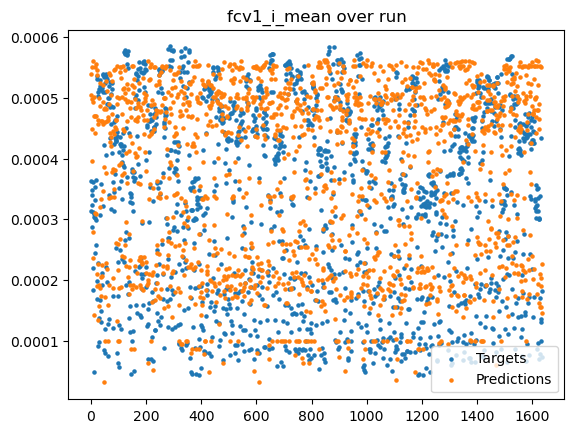

In [167]:
x_axis = range(val_x.shape[0])
targets = val_y
predictions = rf.predict(val_x)
plt.scatter(x_axis, targets, s=5, label="Targets", )
plt.scatter(x_axis, predictions,s=5, label="Predictions")
plt.title("fcv1_i_mean over run")
plt.legend()
plt.show()

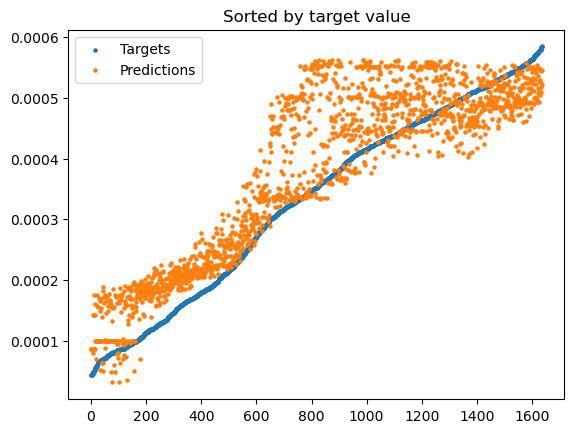

In [168]:
indices = np.argsort(val_y)
targets = val_y[indices]
predictions = rf.predict(val_x)
predictions = predictions[indices]
plt.scatter(x_axis, targets, s=5, label="Targets", )
plt.scatter(x_axis, predictions,s=5, label="Predictions")
plt.legend()
plt.title("Sorted by target value")
plt.show()